In [1]:
# https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html
# https://arxiv.org/abs/1701.02434
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from collections import defaultdict
%config InlineBacked.figure_format = 'retina'
SEED = [20100420, 20100234]

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.5


### Eight schools model

In [2]:
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
# tau = 25.

### A centered eight schools implementation
- pathological geometry that frustrates geometric ergodicity
- resulting subtle bias

In [3]:
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

### A dangerously short Markov chain

In [4]:
with Centered_eight:
    short_trace = pm.sample(600, chains=2, random_seed=SEED)

Sampling 2 chains: 100%|██████████| 2200/2200 [00:05<00:00, 411.30draws/s]


In [5]:
pm.summary(short_trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.92,2.98,0.17,-1.67,10.30,255.15,1.00
theta__0,6.78,5.20,0.28,-2.61,17.04,137.14,1.03
theta__1,5.34,4.42,0.18,-4.01,14.72,524.36,1.00
theta__2,4.45,4.75,0.20,-5.36,13.23,445.37,1.00
theta__3,5.36,4.69,0.21,-3.58,15.70,415.04,1.00
theta__4,4.12,4.38,0.18,-5.63,12.36,418.62,1.00
theta__5,4.57,4.41,0.19,-5.01,12.71,413.21,1.00
theta__6,6.77,4.67,0.24,-1.59,17.06,203.87,1.01
theta__7,5.52,5.23,0.20,-5.55,15.22,500.04,1.00
tau,3.69,3.09,0.22,0.55,9.55,26.74,1.07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22b994e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c22c09400>]], dtype=object)

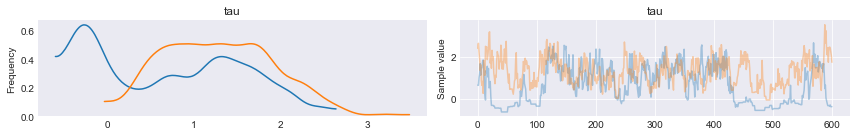

In [6]:
pm.traceplot(short_trace, varnames=['tau'], transform=np.log)

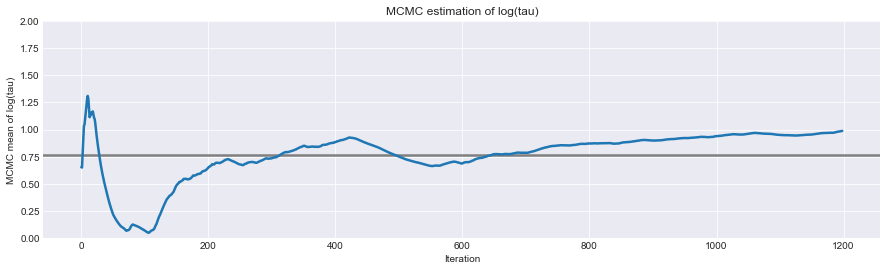

In [7]:
logtau = np.log(short_trace['tau'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]

plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')

In [8]:
divergent = short_trace['diverging']
print('Number of divergent {}'.format(divergent.nonzero()[0].size))

divperc = divergent.nonzero()[0].size / len(short_trace) * 100
print('Percentage of Divergent {} %'.format(divperc))

Number of divergent 68
Percentage of Divergent 11.333333333333332 %


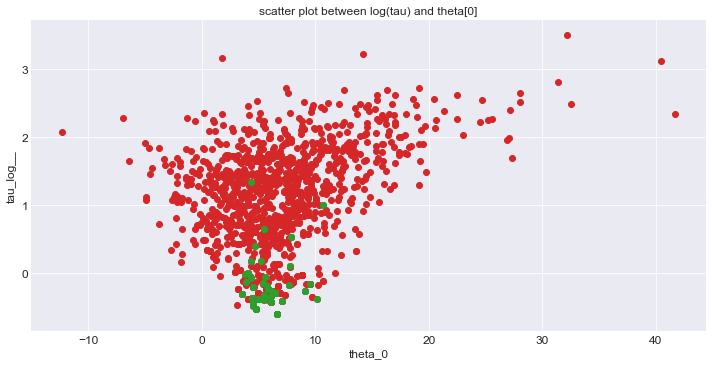

In [9]:
pm.pairplot(short_trace,
           sub_varnames=['theta_0', 'tau_log__'],
           divergences=True,
           color='C3', figsize=(10, 5),
           kwargs_divergence={'color': 'C2'})
plt.title('scatter plot between log(tau) and theta[0]')

In [10]:
divergent_point = defaultdict(list)

chain_warn = short_trace.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in Centered_eight.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])
for RV in Centered_eight.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])
ii = 5

tau_log_d = divergent_point['tau_log__']
theta0_d = divergent_point['theta'][:, ii]
Ndiv_recorded = len(tau_log_d)

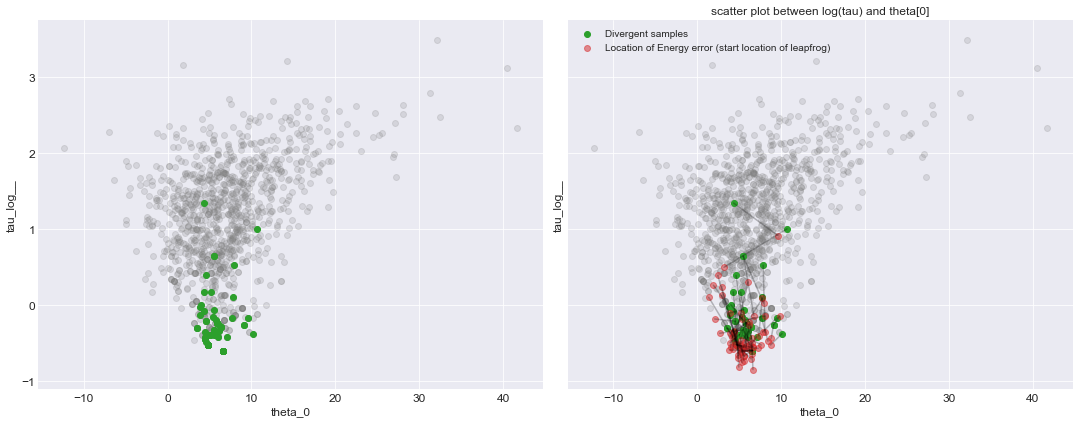

In [11]:
_, ax = plt.subplots(1, 2, figsize=(15, 6), 
                     sharex=True, sharey=True)

pm.pairplot(short_trace, 
           sub_varnames=['theta_0', 'tau_log__'],
           divergences=True,
           ax=ax[0],
           color='C7',
           figsize=(12, 10),
           alpha=0.2,
           kwargs_divergence={'color': 'C2'})

plt.title('scatter plot between log(tau) and theta[5]')

pm.pairplot(short_trace,
               sub_varnames=['theta_0', 'tau_log__'],
               divergences=True,
               ax=ax[1],
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

theta_trace = short_trace['theta']
theta0 = theta_trace[:, 0]

plt.plot([theta0[divergent == 1][:Ndiv_recorded], theta0_d],
           [logtau[divergent == 1][:Ndiv_recorded], tau_log_d],
           'k-', alpha=.25)

plt.scatter(theta0_d, tau_log_d,
              color='C3', alpha=.5, label='Location of Energy error (start location of leapfrog)')

plt.title('scatter plot between log(tau) and theta[0]')
plt.legend();

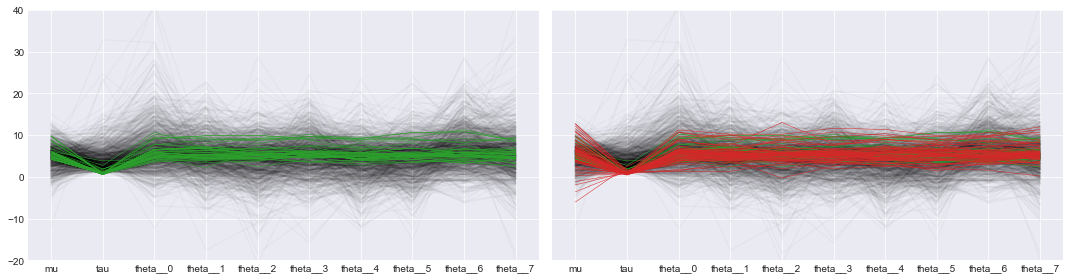

In [12]:
tracedf = pm.trace_to_dataframe(short_trace)
plotorder = ['mu', 'tau', 'theta__0', 'theta__1', 'theta__2', 'theta__3', 'theta__4',
             'theta__5', 'theta__6', 'theta__7']
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)
ax[0].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)

ax[1].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[1].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)
divsp = np.hstack([divergent_point['mu'][:,None],
                   np.exp(divergent_point['tau_log__'])[:,None],
                   divergent_point['theta']])
ax[1].plot(divsp.T, 'C3', lw=.5)
plt.ylim([-20,40])
plt.xticks(range(10), plotorder)
plt.tight_layout();

### A safer, longer Markov chain

In [44]:
def report_trace(trace):
    pm.traceplot(trace, varnames=['tau'], transform=np.log)
    
    logtau = np.log(trace['tau'])
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]

    plt.figure(figsize=(15, 4))
    plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log(tau)')
    plt.title('MCMC estimation of log(tau)')
    
    pm.pairplot(trace,
           sub_varnames=['theta_0', 'tau_log__'],
           divergences=True,
           color='C3', figsize=(10, 5),
           kwargs_divergence={'color': 'C2'})
    plt.title('scatter plot between log(tau) and theta[0]')

In [13]:
with Centered_eight:
    longer_trace = pm.sample(4000, chains=2, tune=1000, random_seed=SEED)

Sampling 2 chains: 100%|██████████| 10000/10000 [00:22<00:00, 453.02draws/s]


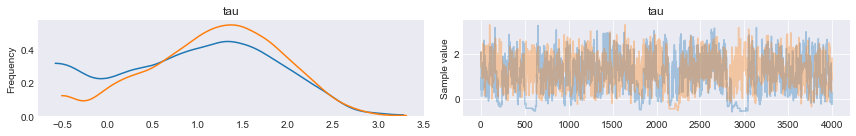

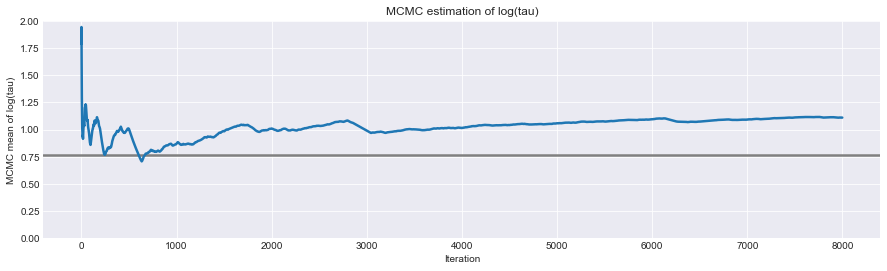

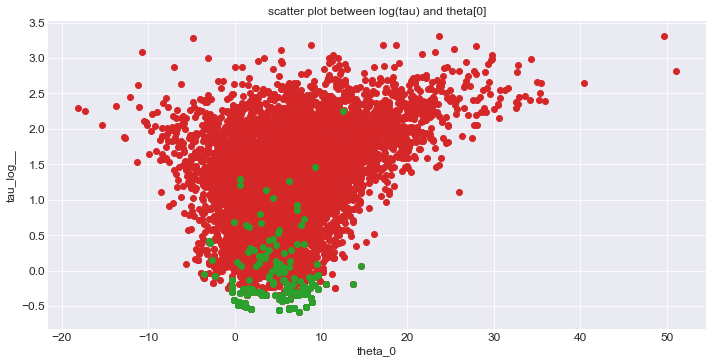

In [45]:
report_trace(longer_trace)

In [15]:
pm.summary(longer_trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.29,3.32,0.11,-2.27,10.45,534.78,1.0
theta__0,6.39,5.80,0.15,-3.92,19.27,1419.56,1.0
theta__1,4.94,4.86,0.12,-4.65,14.51,1490.58,1.0
theta__2,3.73,5.44,0.13,-7.24,14.59,1391.03,1.0
theta__3,4.69,4.94,0.11,-5.62,14.41,1469.06,1.0
theta__4,3.44,4.73,0.13,-6.21,12.50,899.36,1.0
theta__5,3.87,5.02,0.12,-6.74,13.26,1143.95,1.0
theta__6,6.39,5.33,0.15,-3.46,17.33,1193.24,1.0
theta__7,4.79,5.53,0.13,-6.68,15.83,1931.94,1.0
tau,4.04,3.13,0.14,0.56,10.18,396.87,1.0


### Adjusting adaptation routine

In [30]:
with Centered_eight:
    fit_cp85 = pm.sample(5000, chains=2, tune=2000, nuts_kwargs={'target_accept': .85})

Sampling 2 chains: 100%|██████████| 14000/14000 [00:21<00:00, 649.37draws/s] 


In [26]:
with Centered_eight:
    fit_cp90 = pm.sample(5000, chains=2, tune=2000, nuts_kwargs={'target_accept': .9})

Sampling 2 chains: 100%|██████████| 14000/14000 [00:28<00:00, 494.12draws/s]


In [27]:
with Centered_eight:
    fit_cp95 = pm.sample(5000, chains=2, tune=2000, nuts_kwargs={'target_accept': .95})

Sampling 2 chains: 100%|██████████| 14000/14000 [00:31<00:00, 444.74draws/s]


In [28]:
with Centered_eight:
    fit_cp99 = pm.sample(5000, chains=2, tune=2000, nuts_kwargs={'target_accept': .99})

Sampling 2 chains: 100%|██████████| 14000/14000 [03:25<00:00, 68.23draws/s] 


In [33]:
df = pd.DataFrame([longer_trace['step_size'].mean(),
                                  fit_cp85['step_size'].mean(),
                                  fit_cp90['step_size'].mean(),
                                  fit_cp95['step_size'].mean(),
                                  fit_cp99['step_size'].mean(),], columns=['Step_size'])
df['Divergent'] = pd.Series([longer_trace['diverging'].sum(),
                            fit_cp85['diverging'].sum(),
                            fit_cp90['diverging'].sum(),
                            fit_cp95['diverging'].sum(),
                            fit_cp99['diverging'].sum(),])
df['delta_target'] = pd.Series(['.80', '.85', '.90', '.95', '.99'])
df

,Step_size,Divergent,delta_target
0,0.242787,324,.80
1,0.226000,515,.85
2,0.255232,333,.90
3,0.149843,338,.95
4,0.011223,81,.99


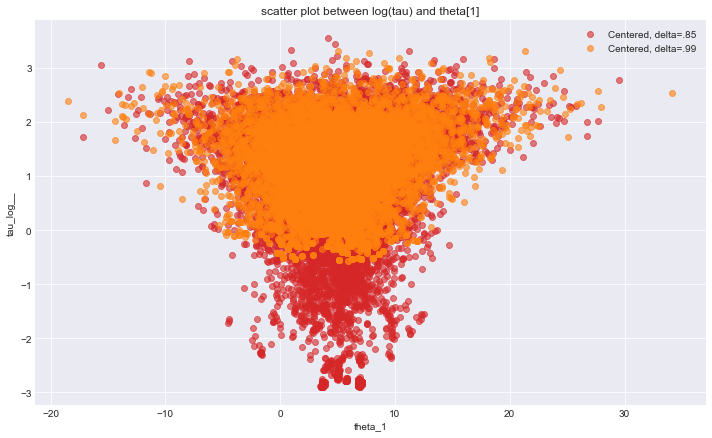

In [35]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
pm.pairplot(fit_cp99, sub_varnames=['theta_1', 'tau_log__'], ax=ax, color='C3', 
            alpha=0.6, label='Centered, delta=.85')

pm.pairplot(longer_trace, sub_varnames=['theta_1', 'tau_log__'], ax=ax, color='C1', 
            alpha=0.6, label='Centered, delta=.99')

plt.title('scatter plot between log(tau) and theta[1]')
plt.legend()

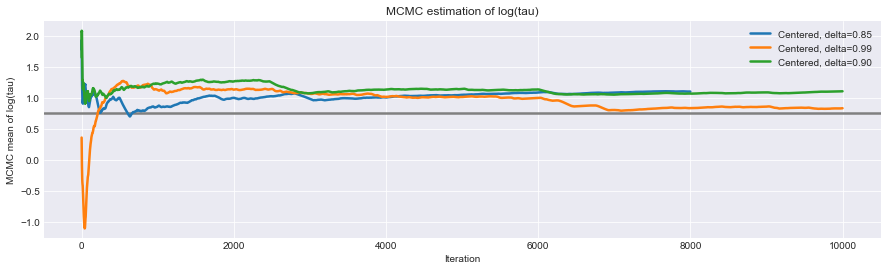

In [39]:
logtau0 = longer_trace['tau_log__']
logtau2 = np.log(fit_cp90['tau'])
logtau1 = fit_cp99['tau_log__']

plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')

mlogtau0 = [np.mean(logtau0[:i]) for i in range(1, len(logtau0))]
plt.plot(mlogtau0, label='Centered, delta=0.85', lw=2.5)

mlogtau1 = [np.mean(logtau1[:i]) for i in range(1, len(logtau1))]
plt.plot(mlogtau1, label='Centered, delta=0.99', lw=2.5)

mlogtau2 = [np.mean(logtau2[:i]) for i in range(1, len(logtau2))]
plt.plot(mlogtau2, label='Centered, delta=0.90', lw=2.5)

plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend()

### A non-centered eight schools implementation

In [40]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_t', mu=0, sd=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [41]:
with NonCentered_eight:
    fit_ncp80 = pm.sample(5000, chains=2, tune=1000, random_seed=SEED, nuts_kwargs={'target_accept': .8})

Sampling 2 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1238.55draws/s]


In [42]:
pm.summary(fit_ncp80).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.46,3.30,0.03,-1.86,10.92,14844.29,1.0
theta_t__0,0.31,0.97,0.01,-1.55,2.24,11547.14,1.0
theta_t__1,0.08,0.95,0.01,-1.90,1.84,13396.31,1.0
theta_t__2,-0.09,0.97,0.01,-2.10,1.68,13279.63,1.0
theta_t__3,0.06,0.93,0.01,-1.82,1.84,14101.84,1.0
theta_t__4,-0.16,0.92,0.01,-1.93,1.69,15728.37,1.0
theta_t__5,-0.08,0.94,0.01,-1.96,1.72,14153.23,1.0
theta_t__6,0.35,0.97,0.01,-1.51,2.30,14095.27,1.0
theta_t__7,0.08,0.97,0.01,-1.92,1.90,17033.08,1.0
tau,3.60,3.27,0.04,0.00,9.90,5185.66,1.0


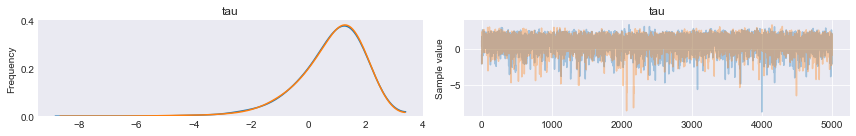

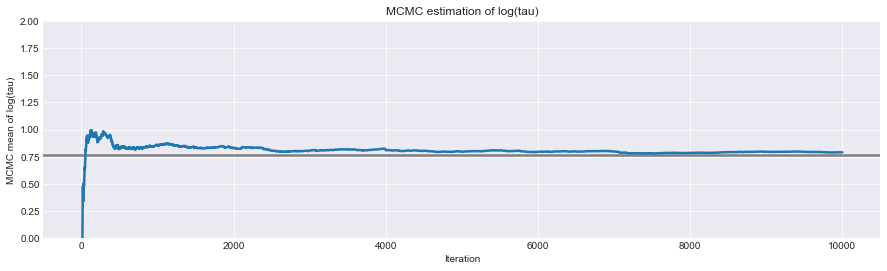

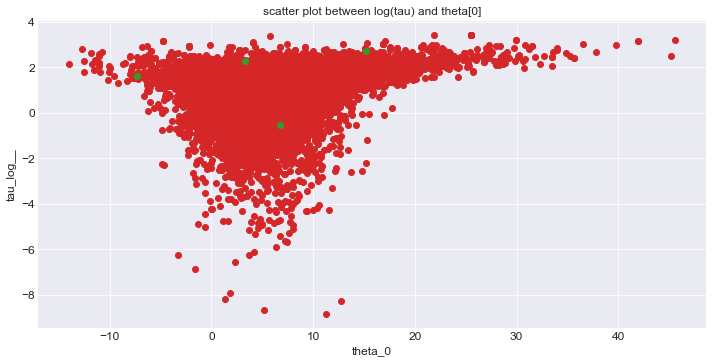

In [46]:
report_trace(fit_ncp80)

In [48]:
with NonCentered_eight:
    fit_ncp90 = pm.sample(5000, chains=2, tune=1000, random_seed=SEED, nuts_kwargs={'target_accept': .9})

# display total number and percentage of divergent
divergent = fit_ncp90['diverging']
print('Number of divergent {}'. format(divergent.nonzero()[0].size))

Sampling 2 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1012.35draws/s]

Number of divergent 0


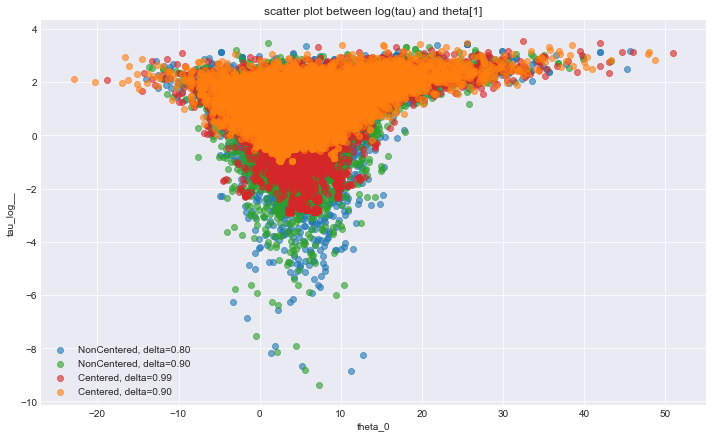

In [50]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))

pm.pairplot(fit_ncp80, sub_varnames=['theta_0', 'tau_log__'], ax=ax,
               color='C0', alpha=0.6, label='NonCentered, delta=0.80')

pm.pairplot(fit_ncp90, sub_varnames=['theta_0', 'tau_log__'], ax=ax,
               color='C2', alpha=0.6, label='NonCentered, delta=0.90')

pm.pairplot(fit_cp99, sub_varnames=['theta_0', 'tau_log__'], ax=ax,
               color='C3', alpha=0.6, label='Centered, delta=0.99')

pm.pairplot(fit_cp90, sub_varnames=['theta_0', 'tau_log__'], ax=ax,
               color='C1', alpha=0.6, label='Centered, delta=0.90')


plt.title('scatter plot between log(tau) and theta[1]')
plt.legend();

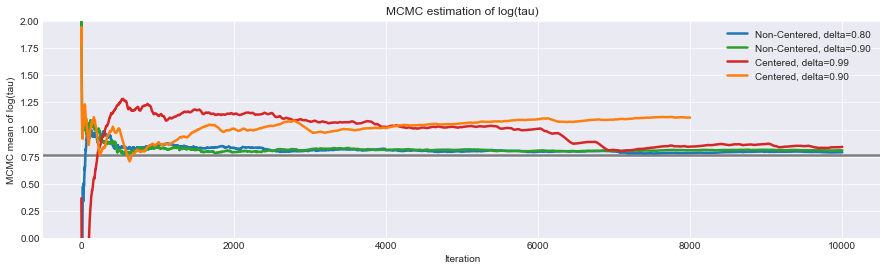

In [52]:
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')

logtaun = fit_ncp80['tau_log__']
mlogtaun = [np.mean(logtaun[:i]) for i in np.arange(1, len(logtaun))]
plt.plot(mlogtaun, color='C0', lw=2.5, label='Non-Centered, delta=0.80')

logtaun = fit_ncp90['tau_log__']
mlogtaun2 = [np.mean(logtaun[:i]) for i in np.arange(1, len(logtaun))]
plt.plot(mlogtaun2, color='C2', lw=2.5, label='Non-Centered, delta=0.90')

mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1, len(logtau1))]
plt.plot(mlogtau1, color='C3', lw=2.5, label='Centered, delta=0.99')

mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1, len(logtau0))]
plt.plot(mlogtau0, color='C1', lw=2.5, label='Centered, delta=0.90')

plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend();